# Caracterização de eletrofáceis por meio de inteligência artificial com abordagem supervisionada
## Treinamento teste e análise do modelo

- **Nome do Arquivo**: treinamento_modelo.ipynb
- **Autor**: Rafael Takeguma Goto
- **Versão**: 1.0
- **Data de Criação**: 24/06/2024
- **Data de Modificação**: 26/07/2024

### Descrição: 
Este notebook contém a etapa do trabalho referente à realização do treinamento, teste e análise do algoritmo de identificação de eletrofáceis a partir dos dados rotulados.

### Leitura do conjunto de dados
O conjunto de dados é constituído por um arquivo csv, que é resultado da concatenação dos arquivos csv gerados a partir da fusão da extração dos arquivos dlis com os arquivos agp de cada poço, seguida da aplicação dos seguintes processamentos:
- filtros de constantes 
- filtros de nulos
- filtros de perfis (DCAL e DRHO)
- reclassificação da litologia metamórfica

In [1]:
import pandas as pd

path_pocos_pre_transicao = 'Dados-filtrados-concatenados\pocos_pre_transicao_v2.csv'

dados_concatenados_leitura = pd.read_csv(path_pocos_pre_transicao)

dados_concatenados = pd.DataFrame(dados_concatenados_leitura)

### Transforma valores categóricos das unidades em inteiros
Transforma os valores das unidades geológicas, contidos na coluna UnidadeF e UnidadeM, em valores inteiros

In [2]:
# Separa todas as unidades presentes nos dados
unidadeF_unicos = dados_concatenados['UnidadeF'].unique()
unidadeM_unicos = dados_concatenados['UnidadeM'].unique()

# Cria mapeamento para os valores únicos em UnidadeF e UnidadeM
unidadeF_mapeamento = {value: index for index, value in enumerate(unidadeF_unicos)}
unidadeM_mapeamento = {value: index for index, value in enumerate(unidadeM_unicos)}

# Aplica o mapeamento ao DataFrame dados_concatenados
dados_concatenados['UnidadeF_num'] = dados_concatenados['UnidadeF'].map(unidadeF_mapeamento)
dados_concatenados['UnidadeM_num'] = dados_concatenados['UnidadeM'].map(unidadeM_mapeamento)

### Verifica quantidade total de amostras por litologia

In [3]:
"""
# armazena as diferentes litologias existentes na variável 'litologias'
litologias = dados_concatenados['Litologia'].unique()

for litologia in litologias:
    qtde_litologia = len(dados_concatenados[dados_concatenados['Litologia'] == litologia])
    print(f'{litologia}: {qtde_litologia} registros')
"""

"\n# armazena as diferentes litologias existentes na variável 'litologias'\nlitologias = dados_concatenados['Litologia'].unique()\n\nfor litologia in litologias:\n    qtde_litologia = len(dados_concatenados[dados_concatenados['Litologia'] == litologia])\n    print(f'{litologia}: {qtde_litologia} registros')\n"

### Verifica quantidade de amostras para treinamento por litologia

In [4]:
"""
litologia_train_set = pd.DataFrame(y_train)

for litologia in litologias:
    qtde_litologia = len(litologia_train_set[litologia_train_set['Litologia'] == litologia])
    print(f'{litologia}: {qtde_litologia} registros')
"""


"\nlitologia_train_set = pd.DataFrame(y_train)\n\nfor litologia in litologias:\n    qtde_litologia = len(litologia_train_set[litologia_train_set['Litologia'] == litologia])\n    print(f'{litologia}: {qtde_litologia} registros')\n"

### Função para criar, treinar e testar o modelo
Cria função cria_modelo(dados, unidades), que toma como parâmetros os dados das litologias, perfis e unidades (se unidades for True) e retorna o modelo treinado.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

def cria_modelo(dados, unidades=bool):
    """
    Função que treina, testa e retorna o modelo.
    Divide os dados armazenados em dados em 2/3 para treinamento do modelo, 
    e 1/3 para teste do modelo.
    Utiliza os dados de treinamento armazenados em X_train e y_train 
    para treinar o modelo de classificação. 
    De forma semelhante, utiliza os dados de teste armazenados em X_test e y_test 
    para testar a acurácia do modelo.
    Por fim, retorna o modelo.
    

    Args:
        dados(DataFrame): DataFrame pandas que contém os dados das curvas, litologias e unidades
        unidades(bool): Verdadeiro ou Falso. Unidades serão variáveis preditivas ou não.

    Returns:
        modelo(sklearn.ensemble._forest.RandomForestClassifier): Modelo treinado
        y_pred(numpy.ndarray): Dados preditos para serem usados na matriz de confusão
        y_test(pandas.core.series.Series): Dados de teste para serem usados na matriz de confusão
    """
    # Define se as unidades geológicas serão incluídas ou não
    if unidades == False:
        # Define as variáveis preditivas que serão utilizadas (apenas propriedades de perfis, sem unidades geológicas) 
        variaveis_preditivas = ['GR', 'DCAL', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE']
    else:
        # Define as variáveis preditivas que serão utilizadas (propriedades de perfis e unidades geológicas)
        variaveis_preditivas = ['GR', 'DCAL', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE', 'UnidadeF_num', 'UnidadeM_num']

    # Separa as variáveis preditivas e armazena em X
    X = dados[variaveis_preditivas] 

    # Separa a variável alvo (litologia) e armazena em y
    y = dados['Litologia']   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

    # Treina o modelo
    modelo = RandomForestClassifier()
    modelo.fit(X_train, y_train)

    # Faz previsões com o modelo
    y_pred = modelo.predict(X_test)

    # Calcula a acuracia
    acuracia = accuracy_score(y_test, y_pred)
    print(f"Acurácia do modelo: {acuracia:2f}")

    return modelo, y_pred, y_test

In [6]:
modelo_01, dados_preditos, dados_verdadeiros = cria_modelo(dados_concatenados, False)

Acurácia do modelo: 0.846791


### Matriz de Confusão

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Função para criar a matriz de confusão
def cria_matriz_confusao(matriz_confusao, modelo):
    """
    Cria (plota) matriz de confusão

    Args:
        matriz_confusao (numpy.ndarray): matriz de confusão criada a partir de confusion_matrix().
        modelo (sklearn.ensemble._forest.RandomForestClassifier): modelo RandomForestClassifier()
    """

    # Normaliza a matriz de confusão por linha
    matriz_confusao_normalizada = matriz_confusao.astype('float') / matriz_confusao.sum(axis=1)[:, np.newaxis]
    
    # Rótulos das litologias
    categorias = modelo.classes_

    # Cria strings com os valores absolutos e porcentagem de cada célula da matriz
    num_absoluto_porcentagem = np.empty_like(matriz_confusao, dtype=object)
    for i in range(matriz_confusao.shape[0]):
        for j in range(matriz_confusao.shape[1]):
            num_absoluto_porcentagem[i, j] = f'{matriz_confusao[i, j]}\n{matriz_confusao_normalizada[i, j]:.1%}'
    
    # Tamanho da figura
    plt.figure(figsize=(12,8))
    
    # Objeto dos eixos
    ax = plt.gca()
    
    # Remove traços dos eixos
    ax.tick_params(axis='x', which='both', bottom=False, top=False)  
    ax.tick_params(axis='y', which='both', left=False, right=False)
    
    sns.heatmap(matriz_confusao_normalizada, 
                annot=num_absoluto_porcentagem, 
                fmt='',
                cmap='BuGn', 
                xticklabels=categorias, 
                yticklabels=categorias,
                cbar_kws={'label': 'Proporção da Litologia'},
                annot_kws={"size": 12},
                linewidths=0.7,
                linecolor='gray')
    
    # Rótulos dos eixos
    plt.xlabel('Predito', fontsize=12)
    plt.ylabel('Verdadeiro', fontsize=12)
    
    plt.show()

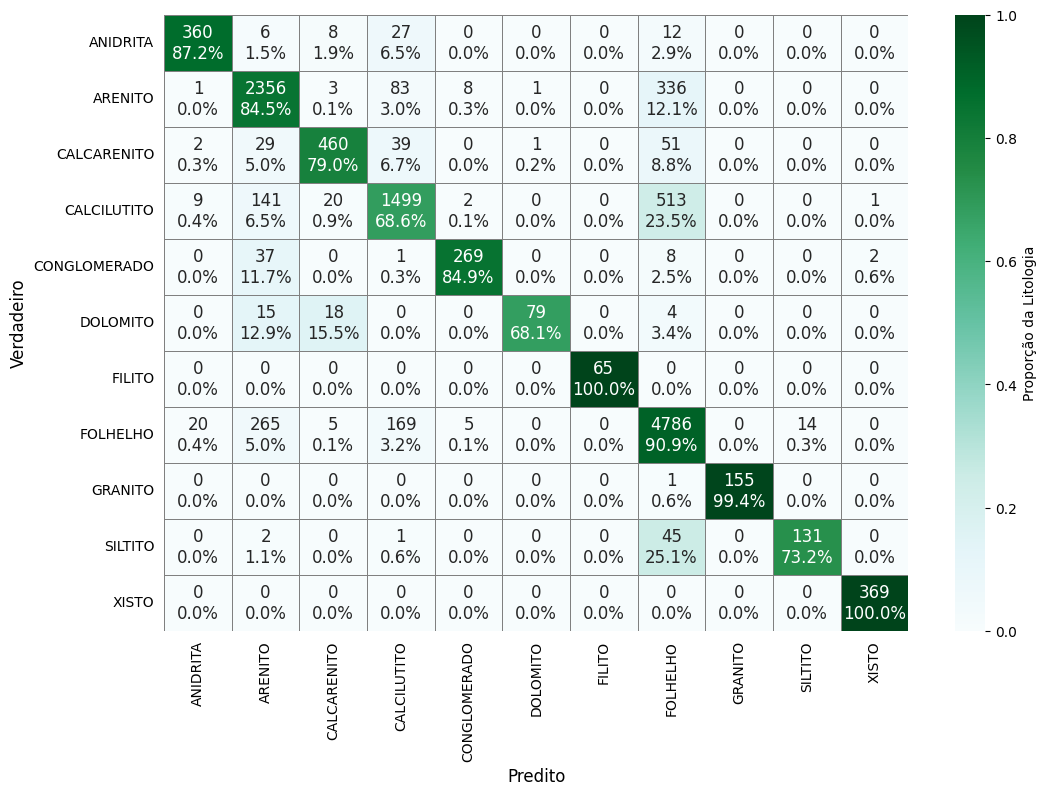

In [12]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_01 = confusion_matrix(dados_verdadeiros, dados_preditos)

cria_matriz_confusao(matriz_confusao_01, modelo_01)

## Dados sem balanceamento e com unidades geológicas

### Divide os dados em treinamento e teste
Divide os dados armazenados em dados_concatenados em 2/3 para treinamento do modelo, e 1/3 para teste do modelo.

In [11]:
# Define as variáveis que serão utilizadas (propriedades de perfis e unidades geológicas) 
propriedades_unidades_geologicas = ['GR', 'DCAL', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE', 'UnidadeF_num', 'UnidadeM_num']

# Separa as variáveis (propriedades de perfis, UnidadeF e UnidadeM) e armazena em X_02
X_02 = dados_concatenados[propriedades_unidades_geologicas]

# Separa a variável alvo (litologia) e armazena em y_01
y_02 = dados_concatenados['Litologia']

# Divide os dados em 2/3 para treinamento e 1/3 para teste
X_02_train, X_02_test, y_02_train, y_02_test = train_test_split(X_02, y_02, test_size=1/3, random_state=42)

### Treinamento e teste do modelo
Utiliza os dados de treinamento armazenados em X_02_train e y_02_train para treinar o modelo de classificação. De forma semelhante, utiliza os dados de teste armazenados em X_02_test e y_02_test para testar a acurácia do modelo.

In [12]:
# Treina o modelo
modelo_02 = RandomForestClassifier()
modelo_02.fit(X_02_train, y_02_train)

# Faz previsões com o modelo
y_02_pred = modelo_02.predict(X_02_test)

# Calcula a acuracia
acuracia_02 = accuracy_score(y_02_test, y_02_pred)
print(f"Acurácia do modelo: {acuracia_02:2f}")

Acurácia do modelo: 0.869551


### Matriz de Confusão

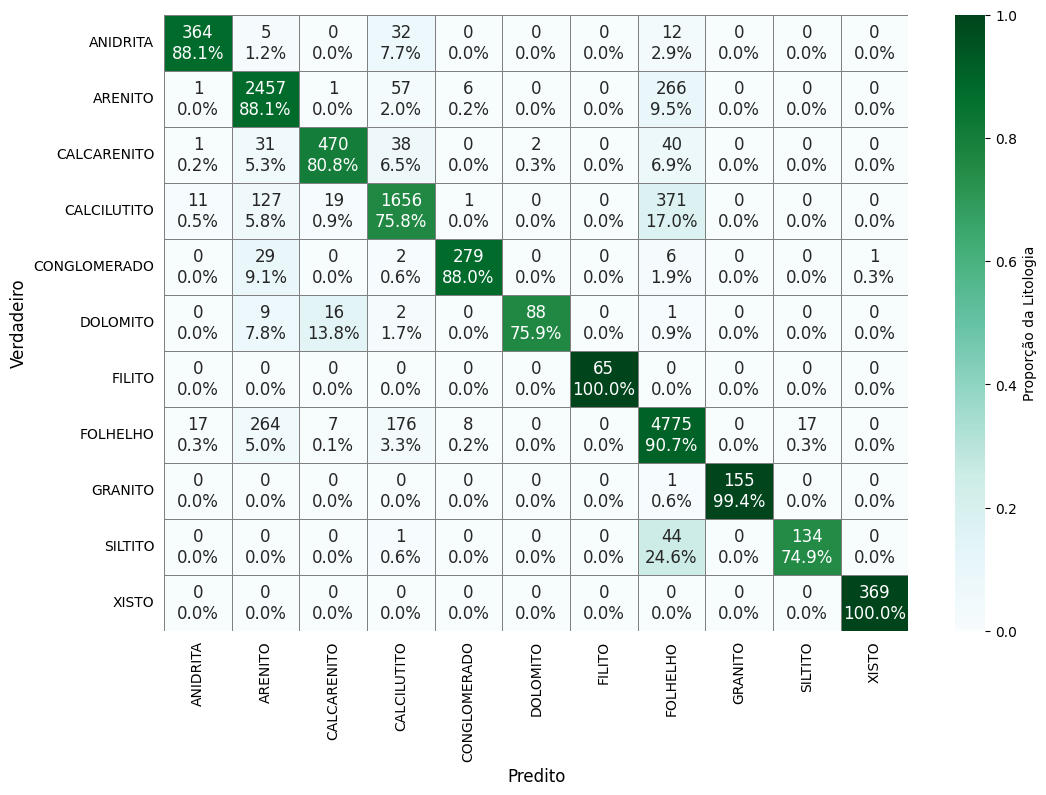

In [13]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_02 = confusion_matrix(y_02_test, y_02_pred)

cria_matriz_confusao(matriz_confusao_02, modelo_02)

## Dados sem balanceamento e com unidades geológicas (como uma única coluna)
### Cria uma nova coluna para as combinações de Formação e Membro

In [14]:
"""
# Cria a nova coluna combinando os valores de UnidadeF e UnidadeM
dados_concatenados['Unidade_comb'] = dados_concatenados['UnidadeF'] + '_' + dados_concatenados['UnidadeM']
"""

"\n# Cria a nova coluna combinando os valores de UnidadeF e UnidadeM\ndados_concatenados['Unidade_comb'] = dados_concatenados['UnidadeF'] + '_' + dados_concatenados['UnidadeM']\n"

### Cria uma coluna numérica para Unidade_comb

In [15]:
"""
# Todas as combinações de Formação e Membro
unidade_comb_unicos = dados_concatenados['Unidade_comb'].unique()

# Cria mapeamento para os valores únicos em Unidade_comb
unidade_comb_mapeamento = {value: index for index, value in enumerate(unidade_comb_unicos)}

# Aplica o mapeamento ao DataFrame dados_concatenados
dados_concatenados['Unidade_comb_num'] = dados_concatenados['Unidade_comb'].map(unidade_comb_mapeamento)
"""

"\n# Todas as combinações de Formação e Membro\nunidade_comb_unicos = dados_concatenados['Unidade_comb'].unique()\n\n# Cria mapeamento para os valores únicos em Unidade_comb\nunidade_comb_mapeamento = {value: index for index, value in enumerate(unidade_comb_unicos)}\n\n# Aplica o mapeamento ao DataFrame dados_concatenados\ndados_concatenados['Unidade_comb_num'] = dados_concatenados['Unidade_comb'].map(unidade_comb_mapeamento)\n"

### Divide os dados em treinamento e teste
Divide os dados armazenados em dados_concatenados em 2/3 para treinamento do modelo, e 1/3 para teste do modelo.

In [16]:
"""
# Define as variáveis que serão utilizadas (propriedades de perfis e unidades geológicas) 
propriedades_unidades_geologicas = ['GR', 'DCAL', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE', 'Unidade_comb_num']

# Separa as variáveis (propriedades de perfis, UnidadeF e UnidadeM) e armazena em X_03
X_03 = dados_concatenados[propriedades_unidades_geologicas]

# Separa a variável alvo (litologia) e armazena em y_03
y_03 = dados_concatenados['Litologia']

# Divide os dados em 2/3 para treinamento e 1/3 para teste
X_03_train, X_03_test, y_03_train, y_03_test = train_test_split(X_03, y_03, test_size=1/3, random_state=42)
"""

"\n# Define as variáveis que serão utilizadas (propriedades de perfis e unidades geológicas) \npropriedades_unidades_geologicas = ['GR', 'DCAL', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE', 'Unidade_comb_num']\n\n# Separa as variáveis (propriedades de perfis, UnidadeF e UnidadeM) e armazena em X_03\nX_03 = dados_concatenados[propriedades_unidades_geologicas]\n\n# Separa a variável alvo (litologia) e armazena em y_03\ny_03 = dados_concatenados['Litologia']\n\n# Divide os dados em 2/3 para treinamento e 1/3 para teste\nX_03_train, X_03_test, y_03_train, y_03_test = train_test_split(X_03, y_03, test_size=1/3, random_state=42)\n"

### Treinamento e teste do modelo
Utiliza os dados de treinamento armazenados em X_03_train e y_03_train para treinar o modelo de classificação. De forma semelhante, utiliza os dados de teste armazenados em X_03_test e y_03_test para testar a acurácia do modelo.

In [17]:
"""
# Treina o modelo
modelo_03 = RandomForestClassifier()
modelo_03.fit(X_03_train, y_03_train)

# Faz previsões com o modelo
y_03_pred = modelo_03.predict(X_03_test)

# Calcula a acuracia
acuracia_03 = accuracy_score(y_03_test, y_03_pred)
print(f"Acurácia do modelo: {acuracia_03:2f}")
"""

'\n# Treina o modelo\nmodelo_03 = RandomForestClassifier()\nmodelo_03.fit(X_03_train, y_03_train)\n\n# Faz previsões com o modelo\ny_03_pred = modelo_03.predict(X_03_test)\n\n# Calcula a acuracia\nacuracia_03 = accuracy_score(y_03_test, y_03_pred)\nprint(f"Acurácia do modelo: {acuracia_03:2f}")\n'

### Matriz de Confusão

In [18]:
"""
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_03 = confusion_matrix(y_03_test, y_03_pred)

cria_matriz_confusao(matriz_confusao_03, modelo_03)
"""

'\n# Cria a matriz de confusão (numpy.ndarray)\nmatriz_confusao_03 = confusion_matrix(y_03_test, y_03_pred)\n\ncria_matriz_confusao(matriz_confusao_03, modelo_03)\n'

## Dados com balanceamento (undersampling) e sem unidades geológicas 
### Realiza undersampling da classe majoritária

In [49]:
# Separar as instâncias de 'FOLHELHO'
folhelho_df = dados_concatenados[dados_concatenados['Litologia'] == 'FOLHELHO']

# Realizar uma amostragem aleatória de 6300 instâncias de 'FOLHELHO'
folhelho_sampled = folhelho_df.sample(n=2000, random_state=42)

In [50]:
# Combinar as instâncias amostradas com as outras categorias
demais_litologias_df = dados_concatenados[dados_concatenados['Litologia'] != 'FOLHELHO']

In [51]:
dados_concatenados_folhelho_under = pd.concat([folhelho_sampled, demais_litologias_df])

In [52]:
# Separar as instâncias de 'FOLHELHO'
arenito_df = dados_concatenados_folhelho_under[dados_concatenados_folhelho_under['Litologia'] == 'ARENITO']

# Realizar uma amostragem aleatória de 6300 instâncias de 'FOLHELHO'
arenito_sampled = arenito_df.sample(n=2000, random_state=42)

# Combinar as instâncias amostradas com as outras categorias
demais_litologias_df_02 = dados_concatenados_folhelho_under[dados_concatenados_folhelho_under['Litologia'] != 'ARENITO']

dados_concatenados_arenito_under = pd.concat([arenito_sampled, demais_litologias_df_02])

In [53]:
# Separar as instâncias de 'FOLHELHO'
calcilutito_df = dados_concatenados_arenito_under[dados_concatenados_arenito_under['Litologia'] == 'CALCILUTITO']

# Realizar uma amostragem aleatória de 6300 instâncias de 'FOLHELHO'
calcilutito_sampled = calcilutito_df.sample(n=2000, random_state=42)

# Combinar as instâncias amostradas com as outras categorias
demais_litologias_df_03 = dados_concatenados_arenito_under[dados_concatenados_arenito_under['Litologia'] != 'CALCILUTITO']

dados_concatenados_calcilutito_under = pd.concat([calcilutito_sampled, demais_litologias_df_03])

### Divide os dados em treinamento e teste
Divide os dados armazenados em dados_concatenados em 2/3 para treinamento do modelo, e 1/3 para teste do modelo.

In [54]:
# Separa as variáveis (propriedades de perfis, UnidadeF e UnidadeM) e armazena em X_03
X_03 = dados_concatenados_calcilutito_under[propriedades_unidades_geologicas]

# Separa a variável alvo (litologia) e armazena em y_03
y_03 = dados_concatenados_calcilutito_under['Litologia']

# Divide os dados em 2/3 para treinamento e 1/3 para teste
X_03_train, X_03_test, y_03_train, y_03_test = train_test_split(X_03, y_03, test_size=1/3, random_state=42)

### Treinamento e teste do modelo
Utiliza os dados de treinamento armazenados em X_03_train e y_03_train para treinar o modelo de classificação. De forma semelhante, utiliza os dados de teste armazenados em X_03_test e y_03_test para testar a acurácia do modelo.

In [55]:
# Treina o modelo
modelo_03 = RandomForestClassifier()
modelo_03.fit(X_03_train, y_03_train)

# Faz previsões com o modelo
y_03_pred = modelo_03.predict(X_03_test)

# Calcula a acuracia
acuracia_03 = accuracy_score(y_03_test, y_03_pred)
print(f"Acurácia do modelo: {acuracia_03:2f}")

Acurácia do modelo: 0.839231


### Matriz de Confusão

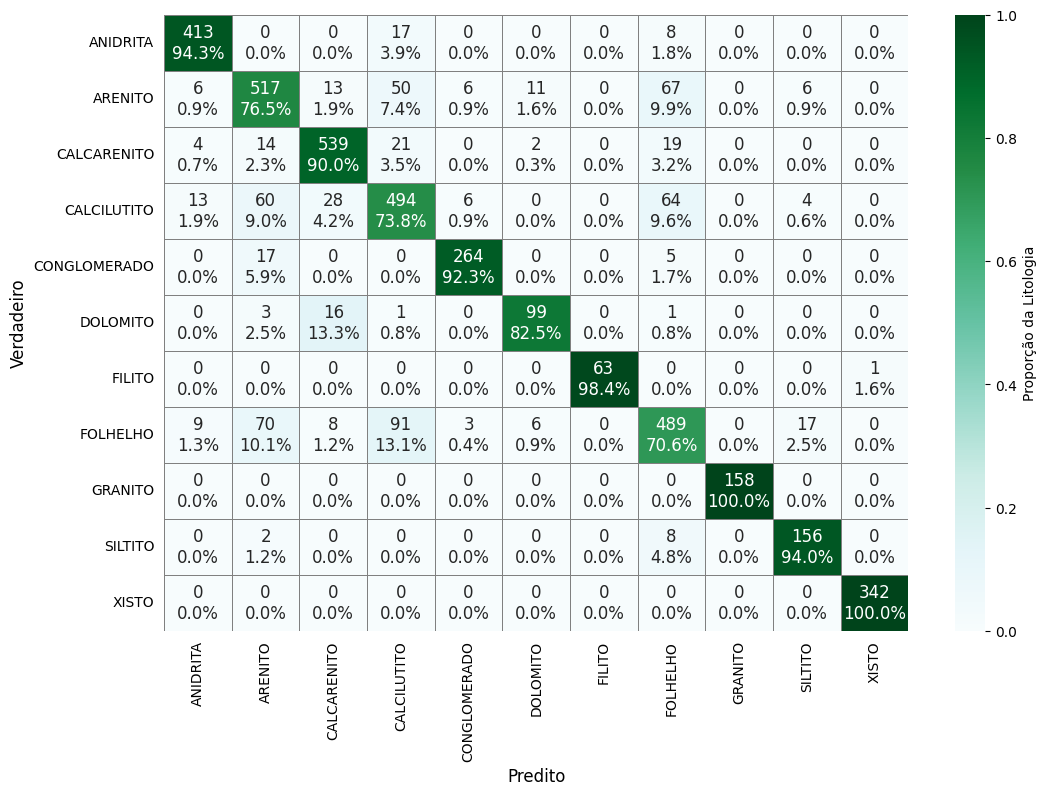

In [56]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_03 = confusion_matrix(y_03_test, y_03_pred)

cria_matriz_confusao(matriz_confusao_03, modelo_03)

### (Testar balancear folhelho por unidades)
### (Testar Quantile Transform)
### (Testar fazer um for para verificar quantidade ótima de folhelho a ser retirado)